## Import Libraries and Data

In [1]:
import PipettingMassBalance as pmb
import pandas as pd
%matplotlib notebook

speciesList = pmb.PipettingSpecies.readCSV('SpeciesDictionary.csv')
instructions = pmb.PipettingInstructions.readCSV('DoE_csv/MasterDataset_OT_DoE_19-25-05-23.csv', firstRow=480, lastRow=486)
targetVolume = 10
sampleList = pmb.PipettingSample.createSamples(instructions,targetVol=targetVolume)
maxVolume = 1
for sample in sampleList:
    sample.getTotalDensity(speciesDictionary=speciesList)
    sample.getVolFracSeries(speciesDictionary=speciesList)
steps = pmb.PipettingStep.createSteps(instructions=instructions,speciesDictionary=speciesList,sampleList=sampleList,maxVol=maxVolume)

massProfile = pmb.MassProfile('mass_data/MassProfile_190523_S481-486.csv',t_baseline=25,derivNoise=0.005,secDerivNoise=0.001)
#default t_baseline=25

## Analyse Water Addition

In [2]:
(water_mass,t1)=massProfile.analyseWater(avg_window=10,bl_mult=5)
water=pmb.PipettingSpecies.getSpecies(speciesList, 'water')
water_volume_act=water.getVolume(water_mass)
water_volume_set=0
for sample in sampleList:
    water_volume = sample.waterVol
    water_volume_set = water_volume_set + water_volume
    sample.actualMass = water_volume/water.density
print("This equals a volume of " + str(round(water_volume_act,3)) + "m; expected was "\
      + str(round(water_volume_set,3)) + "mL; error is " + str(round(abs((water_volume_set-water_volume_act)/water_volume_set)*100,3)) + "%")

Water Transfer started at t=54s and ended at t=496s; mass=44.577149999999996g
This equals a volume of 44.666m; expected was 44.696mL; error is 0.066%


## Analyse Surfactants

Peak threshold for 1st derivative = 0.001 g/s and for 2nd derivative = 0.000375 g/s^2


<IPython.core.display.Javascript object>


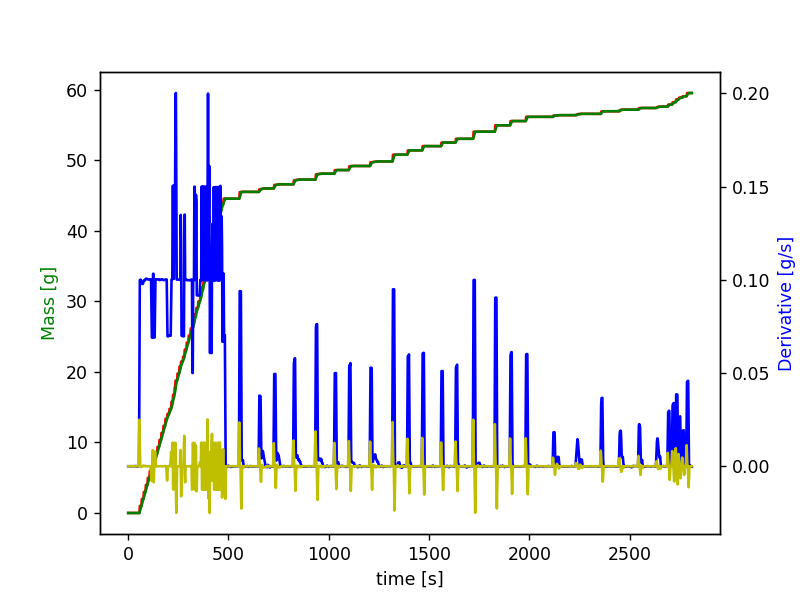

Addition of 0.971g Plantapon ACG 50 detected from 550s to 580s - expected volume = 0.927mL and actual volume = 0.861mL (resulting error is 7.091%)
Addition of 0.486g Plantapon LC 7 detected from 648s to 688s - expected volume = 0.608mL and actual volume = 0.459mL (resulting error is 24.432%)
Addition of 0.595g Plantapon LC 7 detected from 722s to 762s - expected volume = 0.608mL and actual volume = 0.563mL (resulting error is 7.403%)
Addition of 0.673g Plantacare 818 detected from 820s to 864s - expected volume = 0.751mL and actual volume = 0.614mL (resulting error is 18.238%)
Addition of 0.841g Plantacare 2000 detected from 930s to 974s - expected volume = 0.94mL and actual volume = 0.764mL (resulting error is 18.784%)
Addition of 0.519g Dehyton MC detected from 1024s to 1054s - expected volume = 0.519mL and actual volume = 0.481mL (resulting error is 7.274%)
Addition of 0.581g Dehyton MC detected from 1096s to 1132s - expected volume = 0.519mL and actual volume = 0.539mL (resulting e

In [3]:
# default: bl_mult=5, mergeSens=10
t2 = massProfile.analyseIngredients(avg_window=5, bl_mult=5, mergeSens=10, specType='surfactant', steps=steps,start_idx=t1,show=True)

#t2 = massProfile.defineIngredientsManually(specType='surfactant',steps=steps,show=True,manualTimes=[560,600,700,800,900,1000,1100,1150,1250,1320,1400,1500,1580,1650,1730,1830,1920,2000,2080,2140])

## Analyse Polyelectrolytes

Peak threshold for 1st derivative = 0.0015625 g/s and for 2nd derivative = 0.00046875 g/s^2


<IPython.core.display.Javascript object>


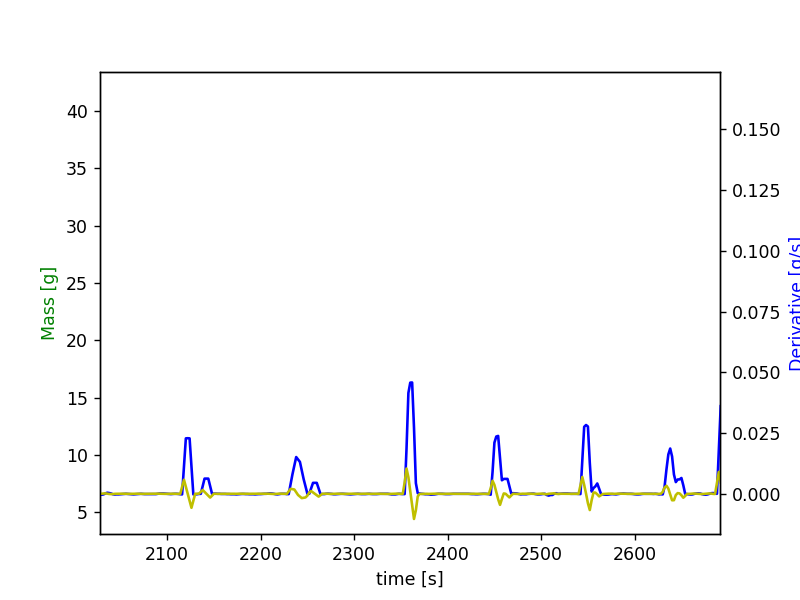

Addition of 0.23g Dehyquart CC6 detected from 2114s to 2152s - expected volume = 0.241mL and actual volume = 0.218mL (resulting error is 9.547%)
Addition of 0.204g Dehyquart CC6 detected from 2228s to 2268s - expected volume = 0.207mL and actual volume = 0.192mL (resulting error is 7.443%)
Addition of 0.367g Dehyquart CC6 detected from 2352s to 2372s - expected volume = 0.273mL and actual volume = 0.344mL (resulting error is 25.945%)
Addition of 0.238g Dehyquart CC6 detected from 2444s to 2472s - expected volume = 0.18mL and actual volume = 0.225mL (resulting error is 24.542%)
Addition of 0.244g Dehyquart CC6 detected from 2540s to 2568s - expected volume = 0.203mL and actual volume = 0.228mL (resulting error is 12.27%)
Addition of 0.194g Dehyquart CC6 detected from 2628s to 2658s - expected volume = 0.154mL and actual volume = 0.185mL (resulting error is 20.186%)


In [4]:
# default bl_mult = 5, default mergeSens = 5
t3 = massProfile.analyseIngredients(avg_window=4, bl_mult=5, mergeSens=5, specType='polyelectrolyte',steps=steps,start_idx=t2,show=True)

#t3 = massProfile.defineIngredientsManually(specType='polyelectrolyte',steps=steps,show=True,manualTimes=[2014,2112,2210,2314,2412,2494,2564])

## Analyse Thickeners

Peak threshold for 1st derivative = 0.005 g/s and for 2nd derivative = 0.001 g/s^2


<IPython.core.display.Javascript object>


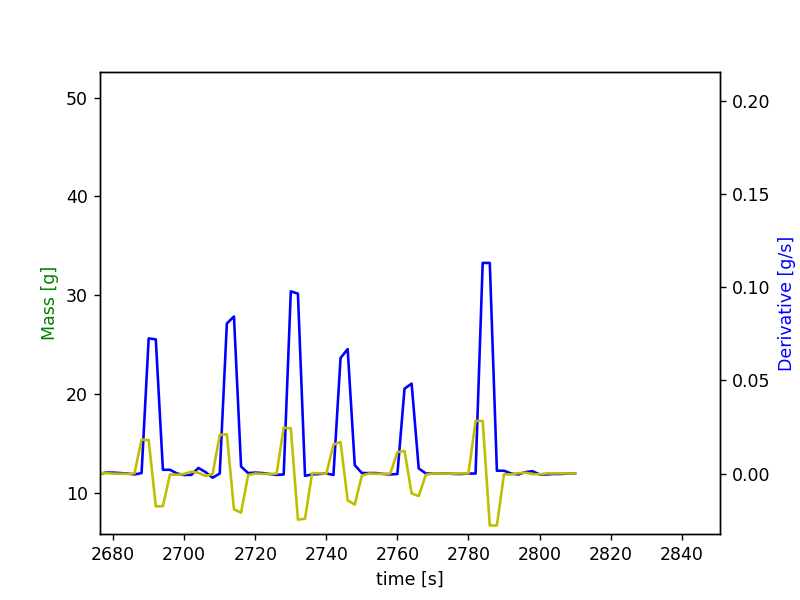

Addition of 0.297g Arlypon F detected from 2686s to 2698s - expected volume = 0.338mL and actual volume = 0.338mL (resulting error is 0.169%)
Addition of 0.34g Arlypon F detected from 2704s to 2720s - expected volume = 0.361mL and actual volume = 0.385mL (resulting error is 6.583%)
Addition of 0.382g Arlypon F detected from 2726s to 2738s - expected volume = 0.41mL and actual volume = 0.431mL (resulting error is 5.096%)
Addition of 0.266g Arlypon F detected from 2740s to 2754s - expected volume = 0.277mL and actual volume = 0.302mL (resulting error is 9.016%)
Addition of 0.191g Arlypon F detected from 2758s to 2770s - expected volume = 0.2mL and actual volume = 0.215mL (resulting error is 7.303%)
Addition of 0.457g Arlypon F detected from 2780s to 2792s - expected volume = 0.501mL and actual volume = 0.525mL (resulting error is 4.691%)


In [5]:
# default bl_mult = 1, default mergeSens = 1
t4 = massProfile.analyseIngredients(avg_window=1, bl_mult=1, mergeSens=1, specType='thickener',steps=steps,start_idx=t3,show=True)

#t4 = massProfile.defineIngredientsManually(specType='thickener',steps=steps,show=True,manualTimes=[2780,2834,2844,2848,2862,2884,2906])

## Consolidate results and create output

In [6]:
for step in steps:
    step.addToSample()
actualMassFractions = pd.DataFrame(dtype='float64').reindex_like(instructions)
actualMassFractions[:]=0
for i in range(len(sampleList)):
    actualMassFractions['ID'].iloc[i] = sampleList[i].sampleId
    for entry in sampleList[i].addedMassSeries.iteritems():
        actualMassFractions[entry[0]].iloc[i] = entry[1]/sampleList[i].actualMass*100
actualMassFractions.to_csv('mass_data/FreshlyAnalysed_190523_S481-S486.csv', index=False)
actualMassFractions

C:\Users\ACHI01\AppData\Local\Temp\ipykernel_36288\3536380807.py:7: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for entry in sampleList[i].addedMassSeries.iteritems():


,ID,Texapon SB 3 KC,Plantapon ACG 50,Plantapon LC 7,Plantacare 818,Plantacare 2000,Dehyton MC,Dehyton PK 45,Dehyton ML,Dehyton AB 30,Plantapon Amino SCG-L,Plantapon Amino KG-L,Dehyquart A-CA,Luviquat Excellence,Dehyquart CC6,Dehyquart CC7 Benz,Salcare Super 7,Arlypon F,Arlypon TT
480,481.0,0.0,0.000000,11.196905,0.00000,0.000000,0.000000,0.0,6.726634,0.0,0.000000,0.000000,0.000000,0.0,2.379070,0.0,0.0,3.070269,0.0
481,482.0,0.0,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.000000,0.0,9.641949,10.493852,0.000000,0.0,2.028874,0.0,0.0,3.387685,0.0
482,483.0,0.0,0.000000,0.000000,0.00000,8.470266,0.000000,0.0,0.000000,0.0,0.000000,0.000000,9.081325,0.0,3.689509,0.0,0.0,3.840512,0.0
483,484.0,0.0,0.000000,0.000000,6.70304,0.000000,0.000000,0.0,0.000000,0.0,0.000000,10.112834,0.000000,0.0,2.369573,0.0,0.0,2.649738,0.0
484,485.0,0.0,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.000000,0.0,12.034166,0.000000,12.036148,0.0,2.413421,0.0,0.0,1.892102,0.0
485,486.0,0.0,9.596789,0.000000,0.00000,0.000000,10.874845,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,1.912636,0.0,0.0,4.522125,0.0
